# 作业内容

> 如果是0.1mm厚的金箔，6MeV的阿尔法粒子穿过时平均散射次数为1.7次。根据泊松分布（设期望为$\lambda = 1.7$）抽取散射次数，并对每次散射，使用微分散射截面中的角度依赖$p(\theta)=\frac{\sin \theta}{\sin^4{\theta/2}}$抽样散射角，最后统计100万个阿尔法粒子穿过此金箔后沿束流方向的动量分布。

# 参考答案

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from tqdm import tqdm

Text(0.5, 1.0, 'times of scattering')

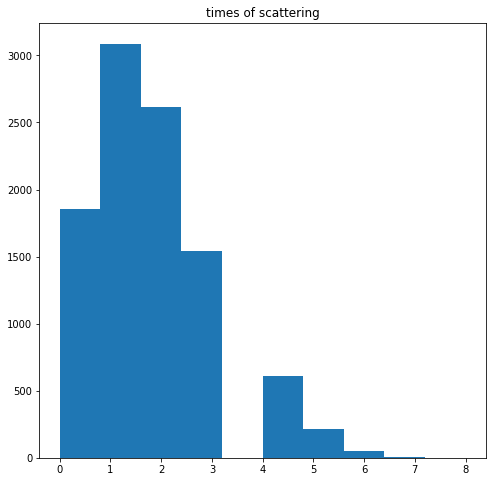

In [2]:
#sampling times of scattering
n = 10000
times = np.random.poisson(1.7, (n,))

#check
fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
ax.hist(times)
ax.set_title('times of scattering')

化简$p(\theta)=\frac{\sin \theta}{\sin^4{\theta/2}}$，显然有$p(\theta)=\frac{2\sin(\theta/2)\cos(\theta/2)}{\sin^4(\theta/2)}$，易得：

$$p(\theta)d\theta=4\frac{d\sin (\theta/2)}{\sin^3(\theta/2)}$$

令$x = \sin(\theta/2)$，那么就可以对$p(x)=Ax^{-3}$抽样

## 蒙特卡洛舍选法

遇到不会做的可以无脑选这个，反正总是能抽出来的

In [3]:
#monte-carlo sampling function
def sampling(func, range_=[[0.1, 1], [0, 1]], n=1000):
    r'''
    Monte-Carlo sampling.
    Args: 3
        func: a function, the pdf. to be sampled.
        range_: a list, [[xmin, xmax], [ymin, ymax]].
        n: an integer, how many variables you want to simulate.
    Return: 1
        res: an array with n variables respect to the pdf. func.
    '''
    [xmin, xmax], [ymin, ymax] = range_
    samples = np.zeros(n, dtype=np.float32)
    i = 0
    while i < n:
        x = np.random.uniform(xmin, xmax)
        y = np.random.uniform(ymin, ymax)
        if y < func(x):
            samples[i] = x
            i = i + 1
    return samples

In [4]:
#define the pdf. function
def raw_func(x):
    return x**(-3)

amplitude, _ = quad(raw_func, 0.1, 1)

def func(x):
    global amplitude
    return raw_func(x) / amplitude

#check
x0 = np.linspace(0.1, 1, 100)
px0 = func(x0)
pmax = px0.max()
pmin = px0.min()
print('Amplitude: {}'.format(amplitude))
print('Maximum of p(k): {}'.format(pmax))
print('Minimum of p(k): {}'.format(pmin))

range_ = [[0.1, 1], [pmin, pmax]]

Amplitude: 49.499999999999986
Maximum of p(k): 20.202020202020204
Minimum of p(k): 0.020202020202020207


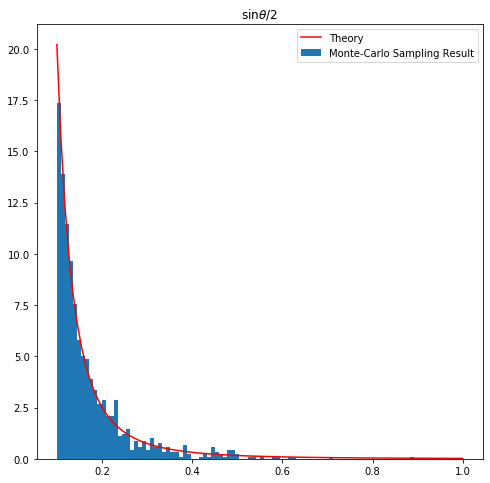

In [5]:
#check sin(theta/2)
x = sampling(func, range_, 1000)
ax.cla()
ax.plot(x0, px0, 'r-', label='Theory')
ax.hist(x, bins=100, range=(0.1, 1), density=True, label='Monte-Carlo Sampling Result')
ax.legend()
ax.set_title(r'$\sin\theta/2$')
fig

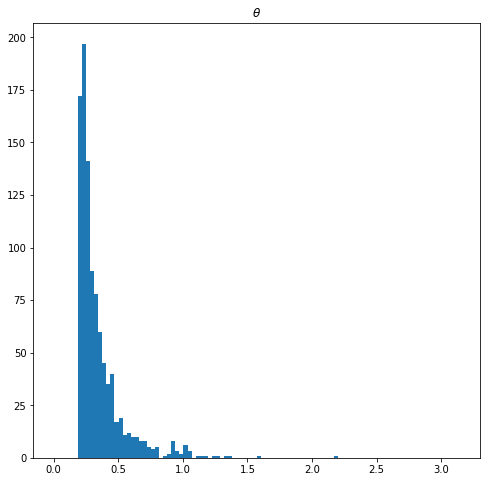

In [6]:
#watch theta
theta = np.arcsin(x) * 2
ax.cla()
ax.hist(theta, bins=100, range=(0, np.pi), density=False)
ax.set_title(r'$\theta$')
fig

## 反函数直接抽样法

由于$\theta \in (0, \pi)$，显然$\theta/x\in (0, \pi/2)$，于是$\sin(\theta/2)\in(0, 1)$

也即上面的$x\in(0,1)$

由于做了0.1的截断，所以x的范围设定在$(0.1, 1)$

十分显然地，有：

$$F(x) = \left\{ \begin{aligned}0, x<0.1;\\
A(-\frac{1}{2}x^{-2}+\frac{1}{2}(-0.1)^{-2}), 0.1\le x \le 1;\\
1\end{aligned}\right.$$

注意到两头的并不需要我们管，因为我们对cdf的抽样在0到1，它们可以看做分别对应了$0-\epsilon$和$1+\epsilon$

所以我们关注中间这一坨就行了，取$x = 1$的时候，对应的就是原函数在$(0.1, 1)$的定积分结果（不考虑归一化），很容易算出来：

$A^{-1} = -\frac{1}{2}(1^{-2}-(0.1)^{-2})\Rightarrow A = 2/99$

所以有$$F(x) = \frac{1}{99}(100 - x^{-2}), 0.1\le x \le 1$$

显然，反函数为：

$$ x(F) = (100 - 99F)^{-1/2} $$

In [7]:
#inverse sampling
def inverse_sampling(func, n=1000):
    r'''
    Inversed function sampling.
    Args: 2
        func: a function, the inverse function. you need to derive its analytical form in advance.
        n: an integer, how many variables you want to simulate.
    Return: 1
        res: an array with n variables respect to the inversed function of func (pdf.).
    '''
    y = np.random.uniform(0, 1, (n,))
    x = func(y)
    return x

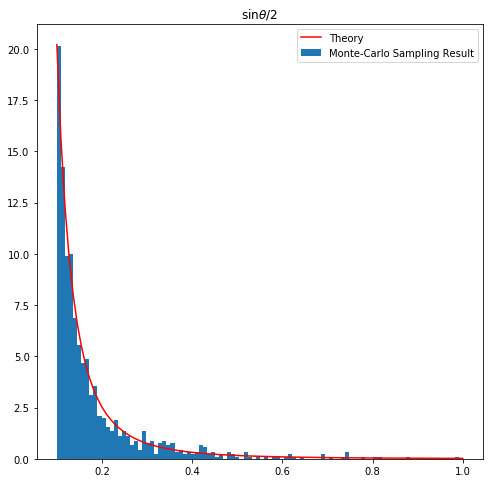

In [8]:
#define the inversed function of pdf.
def inversed_func(f):
    return (100 - 99*f)**(-0.5)

#check sin(theta/2)
x = inverse_sampling(inversed_func, 1000)
ax.cla()
ax.plot(x0, px0, 'r-', label='Theory')
ax.hist(x, bins=100, range=(0.1, 1), density=True, label='Monte-Carlo Sampling Result')
ax.legend()
ax.set_title(r'$\sin\theta/2$')
fig

## 模拟散射过程

有了抽样散射角的函数，就可以模拟散射了。注意到每个粒子发生散射的次数服从泊松分布，而我们一开始就用泊松抽样出了每个粒子的散射次数并储存在times数组里。

接下来定义一个完整的进行n次散射的过程得到最后的散射角的函数，然后依次把散射次数作为参数传进去，就可以得到最终散射角的数组了。

In [9]:
#define a pipline for simulating a whole scattering procedure and returning the final theta
def scatter(nscatter, func, range_, mode):
    r'''
    Get the scattering angle for nscatter times of scattering.
    Args: 4
        nscatter: an integer, how many times of scattering do you need, got this from Poisson dis..
        func: a function, the pdf. to be sampled. or the inversed function.
        range_: a list, [[xmin, xmax], [ymin, ymax]]. or None (for inverse mode).
        mode: a string, 'mc' or 'inverse'.
    Return: 1
        theta: a float, the final scattering angle after nscatter times of scattering.
    '''
    assert(mode in ['mc', 'inverse'])
    if mode == 'mc':
        x_arr = sampling(func, range_=range_, n=nscatter)
    elif mode == 'inverse':
        x_arr = inverse_sampling(func, n=nscatter)
    else:
        raise Exception('invalid mode {}'.format(mode))
    sign_arr = np.random.rand(nscatter)
    sign_arr = np.where(sign_arr>0.5, 1, -1)
    theta_arr = np.arcsin(x_arr) * 2 * sign_arr
    theta = theta_arr.sum()
    return theta

In [10]:
#simulate
theta_arr1 = np.zeros_like(times, dtype=np.float32)
theta_arr2 = np.zeros_like(times, dtype=np.float32)
for idx in tqdm(range(n)):
    theta_arr1[idx] = scatter(times[idx], func, range_, 'mc')
    theta_arr2[idx] = scatter(times[idx], inversed_func, None, 'inverse')

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 12140.28it/s]


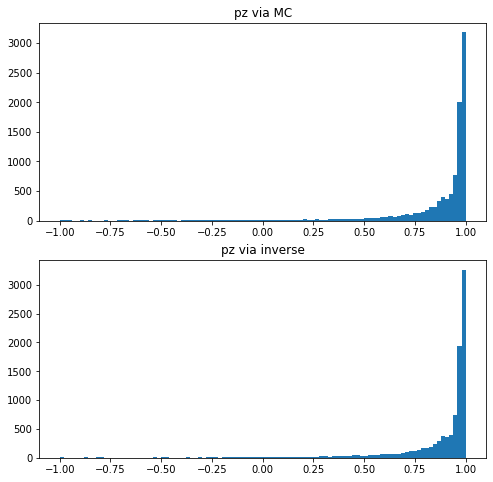

In [11]:
#check
pz1 = np.cos(theta_arr1)
pz2 = np.cos(theta_arr2)
fig.clf()
ax1 = fig.add_subplot(211)
ax1.hist(pz1, bins=100, range=(-1, 1))
ax1.set_title('pz via MC')
ax2 = fig.add_subplot(212)
ax2.hist(pz2, bins=100, range=(-1, 1))
ax2.set_title('pz via inverse')
fig